In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display, HTML


1. Normal (Gaussian) Distribution:
    - Mean (μ): The average or central value of the distribution.
    - Standard deviation (σ): A measure of the spread or dispersion of the distribution around the mean.

  ***Note(empirical formula):***
  1. in normal distribution 68% of data falls under the bell curve between first deviation i.e. μ-σ and μ+σ
  2. 95% of data falls under the bell curve between first deviation i.e. μ-2σ and μ+2σ
  3. 99.7% of data falls under the bell curve between first deviation i.e. μ-3σ and μ+3σ
2. Uniform Distribution:
    - Lower bound (a): The minimum value of the distribution.
    - Upper bound (b): The maximum value of the distribution.
3. Poisson Distribution:
    - Rate parameter (λ): The average rate at which events occur within a fixed interval of time or space.
4. Beta Distribution:
    - Shape parameters (α and β): These parameters control the shape of the distribution and represent the number of successes and failures.


In [ ]:
seed = 42
np.random.seed(seed)

loc = np.random.random((2,))
scale = np.random.random((2,)) * 5 # (gaussian)
# print(loc,scale)

low = -np.random.random((2,)) * 2
high = np.random.random((2,)) * 2 # (uniform)
print(low,high)

lam = np.random.random((2, )) * 3 # (poisson)
# print(lam)

a = np.random.random((2,)) * 2
b = np.random.random((2,)) * 2 # (beta)
# print(a,b)

# True mean
true_means = [*loc, *(high+low)/2, *lam, *(a/(a+b))] # --> q*

[-0.31203728 -0.31198904] [0.11616722 1.73235229]


In [ ]:
def mab(arm=None):
    if arm in [0, 1]:
        return np.random.normal(loc[arm], scale[arm])
    elif arm in [2, 3]:
        arm -= 2
        return np.random.uniform(low[arm], high[arm])
    elif arm in [4, 5]:
        arm -= 4
        return np.random.poisson(lam[arm])
    elif arm in [6, 7]:
        arm -= 6
        return np.random.beta(a[arm], b[arm])

In [ ]:
#pulling each arm 1000 times to get samples for estimation and plotting
rewards = np.zeros((8, 1000))
for arm in range(8):
    for i in range(1000):
        rewards[arm, i] = mab(arm)

In [ ]:
# comparing estimated mean values with true
est_means = [np.mean(rewards[arm]) for arm in range(8)]
df = pd.DataFrame({"Arm": list(range(8)), "True Mean": true_means, "Est. Mean": est_means})
display(HTML((df.to_html(index=False))))

Arm,True Mean,Est. Mean
0,0.374540,0.446731
1,0.950714,1.139722
2,-0.097935,-0.099509
3,0.710182,0.684619
4,1.803345,1.784000
5,2.124218,2.131000
6,0.024131,0.023603
7,0.820394,0.811318


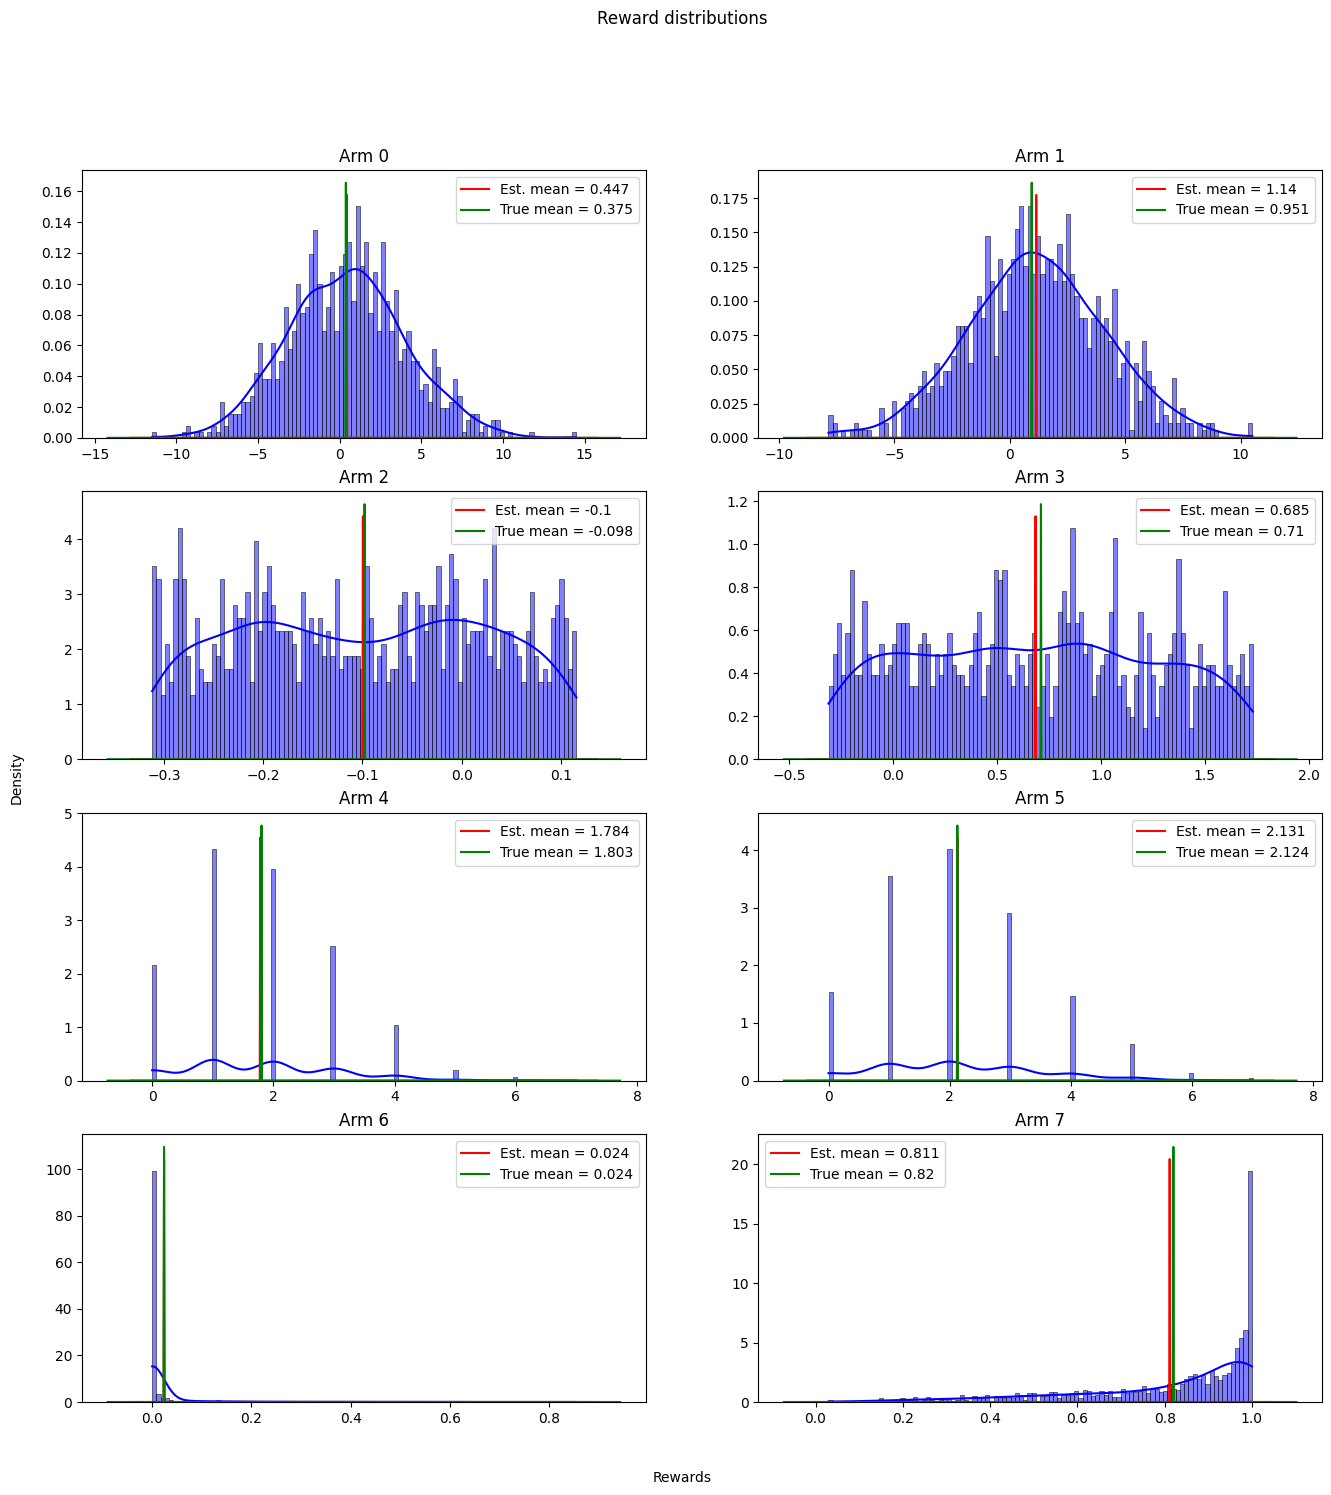

In [ ]:
# plot each distribution

%matplotlib inline

def get_unit_impulse(low, high, val, scale, size=1000):
    x = np.arange(low, high, (high-low)/size)
    y = np.zeros(x.shape)
    y[ np.abs(x-val).argmin() ] = scale
    return x, y

fig, axes = plt.subplots(4, 2, sharex=False, sharey=False, figsize=(16,16))
fig.suptitle('Reward distributions')

for arm in range(8):
    ax = axes[arm//2, arm%2]
    sns.histplot(rewards[arm], ax=ax, stat="density", kde=True, bins=100, color="blue")
    ax.plot(*get_unit_impulse(*ax.get_xlim(), np.mean(rewards[arm]), ax.get_ylim()[1]),
            label="Est. mean = {}".format(round(np.mean(rewards[arm]), 3)), color="red")
    ax.plot(*get_unit_impulse(*ax.get_xlim(), true_means[arm], ax.get_ylim()[1]),
            label="True mean = {}".format(round(true_means[arm], 3)), color="green")
    ax.set_ylabel("")
    ax.set_title(f"Arm {arm}")
    ax.legend()

fig.text(0.5, 0.06, 'Rewards', ha='center')
fig.text(0.08, 0.5, 'Density', va='center', rotation='vertical')
plt.show()

The above approach is an exhaustive approach as we are pulling each arm a 1000 times.
This is not an efficient approach and is very time and resource consuming.

In real world we do not know the distribution of our samples. But we still try to estimate the properties such as mean and variance.

We want to know the optimal arm pull with pulling least number of arms in experimentation

## $\epsilon$-greedy and softmax on Gaussian bandits

## algorithm approach

1. Generate a random number between 0 and 1.
2. If the random number is less than ε, select a random action.
3. Otherwise, select the action with the highest estimated value based on the current policy (exploit)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import beta
from collections import namedtuple

In [ ]:
num_arms = 5

In [ ]:
def pull_MAB(arm=None, mus = None):
    rew = np.random.normal(loc=mus[arm], scale=1)
    return rew

In [ ]:
def eps_greedy(epsilon, num_arms, mus):

    q = np.zeros((num_arms))
    times_sampled = np.zeros((num_arms))
    q_of_all_arms_over_time = [[] for _ in range(num_arms)]


    rewards = []
    regrets_list = []


    for t in range(2000):
        arm = np.argmax(q) if np.random.rand() > epsilon else np.random.randint(num_arms)

        times_sampled[arm] += 1

        rwd = pull_MAB(arm=arm, mus=mus)
        rewards.append(rwd)


        q[arm] += (rwd - q[arm]) / times_sampled[arm]

        for i in range(num_arms):
          q_of_all_arms_over_time[i].append(q[i])




    return q, rewards, q_of_all_arms_over_time

In [ ]:
seed = 42
np.random.seed(seed)


mus = np.random.randn(num_arms)



q1, rewards1, all_q1s = eps_greedy(epsilon=0, num_arms = num_arms, mus = mus)
q2, rewards2, all_q2s = eps_greedy(epsilon=0.01, num_arms = num_arms, mus = mus)
q3, rewards3, all_q3s = eps_greedy(epsilon=0.1, num_arms = num_arms, mus = mus)

**Plotting the convergence of Q-estimates over time**

In [ ]:
def q_plotter(title, qs, mus=None):

    colors = ['r','g','b','y','m']
    plt.figure(figsize=(10,6))

    for arm in range(len(qs)):
        plt.plot(qs[arm], color=colors[arm%5], label = f'Arm {arm}')
        if mus is not None:
            plt.axhline(y = mus[arm], color = colors[arm%5], linestyle = '--')

    plt.legend()
    plt.suptitle(title, fontweight = 'bold', fontsize = 14)
    plt.xlabel("Steps", fontweight = 'bold')
    plt.ylabel("Q-estimate", fontweight = 'bold')
    plt.grid(True)
    plt.show()

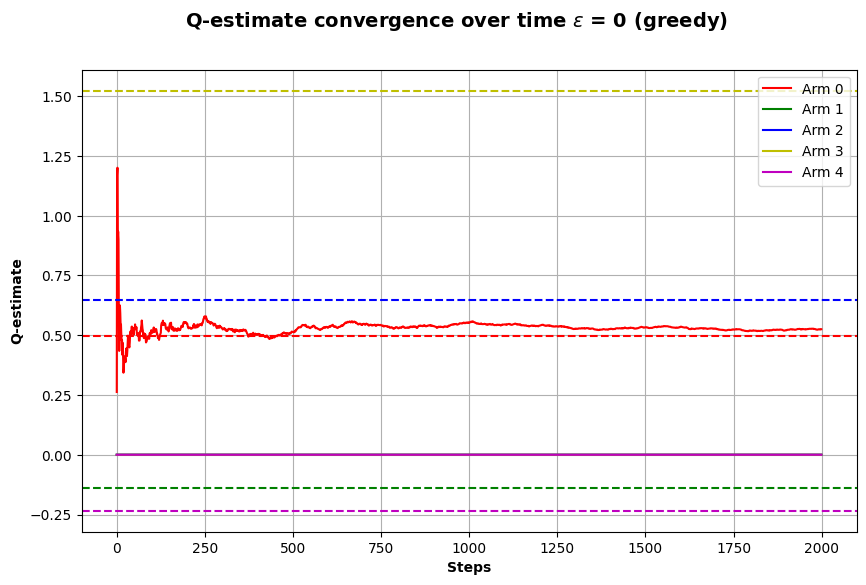

In [ ]:
q_plotter('Q-estimate convergence over time $\epsilon$ = 0 (greedy)', all_q1s, mus = mus)

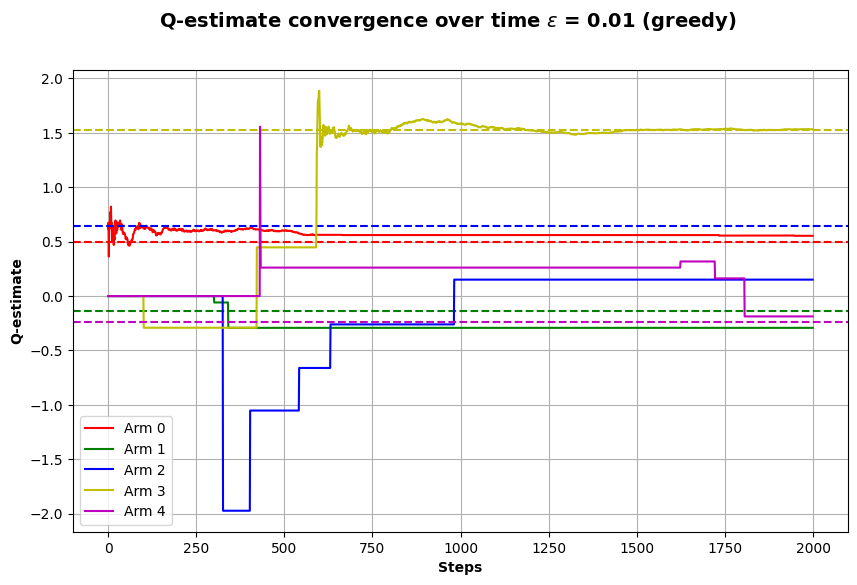

In [ ]:


q_plotter('Q-estimate convergence over time $\epsilon$ = 0.01 (greedy)', all_q2s, mus = mus)

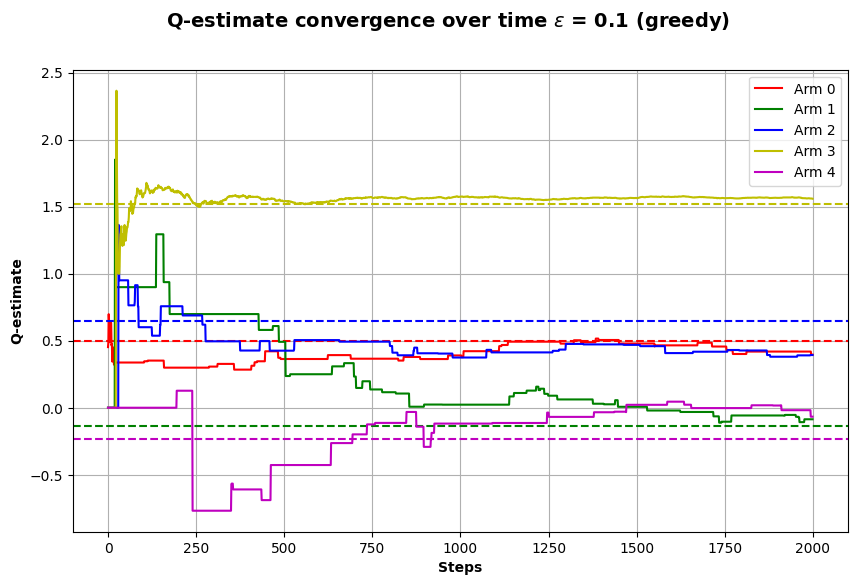

In [ ]:
q_plotter('Q-estimate convergence over time $\epsilon$ = 0.1 (greedy)', all_q3s, mus = mus)

**Task 2: Evaluating the average behaviour of the $\epsilon$-greedy algorithm (averaged over independent runs)**

When we evaluate the average behaviour of the algorithm, we use the average across several runs of the experiment. Similar to earlier, the true means of the Gaussian bandit arms are drawn from a standard normal distribution.

However, the generated true means are different (random) for each independent run.

In [ ]:
def runs_plotter(title, xlbl, ylbl, plots, mu_star):
    plt.figure(figsize=(10,6))
    for values, lbl in plots:
        plt.plot(values, label = lbl)

    plt.legend()

    plt.axhline(mu_star, linestyle = '--', color = 'k',
                label = 'Optimal mean reward')

    plt.suptitle(title, fontweight = 'bold', fontsize = 14)
    plt.xlabel(xlbl, fontweight = 'bold')
    plt.ylabel(ylbl, fontweight = 'bold')
    plt.grid(True)
    plt.show()

In [ ]:

num_runs = 1000


np.random.seed(seed)

# For epsilon = 0
avg_r1 = []
# For epsilon = 0.01
avg_r2 = []
# For epsilon = 0.1
avg_r3 = []


avg_mu_star = 0

for run in range(num_runs):


    mus_run = np.random.randn(num_arms)

    avg_mu_star += np.max(mus_run)

    q1, rewards1, all_q1s = eps_greedy(epsilon=0, num_arms = num_arms, mus = mus_run)
    q2, rewards2, all_q2s = eps_greedy(epsilon=0.01, num_arms = num_arms, mus = mus_run)
    q3, rewards3, all_q3s = eps_greedy(epsilon=0.1, num_arms = num_arms, mus = mus_run)


    avg_r1.append(rewards1)
    avg_r2.append(rewards2)
    avg_r3.append(rewards3)


avg_mu_star /= num_runs
avg_r1 = np.array(avg_r1).mean(axis=0)
avg_r2 = np.array(avg_r2).mean(axis=0)
avg_r3 = np.array(avg_r3).mean(axis=0)


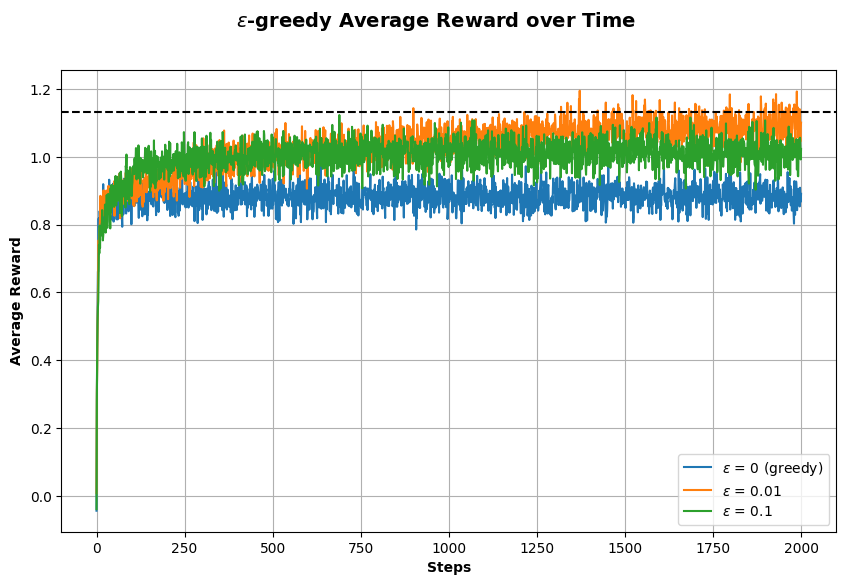

In [ ]:
# Helper code to plot the average rewards

reqd_plots = [(avg_r1, '$\epsilon$ = 0 (greedy)'),
            (avg_r2, '$\epsilon$ = 0.01'),
            (avg_r3, '$\epsilon$ = 0.1')]

runs_plotter(title = '$\epsilon$-greedy Average Reward over Time',
        xlbl = 'Steps', ylbl = 'Average Reward', plots = reqd_plots,
        mu_star = avg_mu_star)

**Task 3: Function to implement the softmax algorithm**

Once again, your task is to fill in the core steps of the softmax action selection and q-estimate updation.

In [ ]:
# Function to implement softmax

def softmax(temp, num_arms, mus):

    q = np.zeros((num_arms))
    times_sampled = np.zeros((num_arms))

    rewards = []

    for t in range(1000):

        exp_prob = np.exp(q/temp)
        prob = exp_prob / np.sum(exp_prob)
        ep = np.random.rand()
        cum, arm = 0, 0
        for i in range(num_arms):
            cum += prob[i]
            if cum > ep:
                arm = i
                break


        times_sampled[arm] += 1
        rwd = pull_MAB(arm=arm, mus=mus)
        rewards.append(rwd)
        q[arm] += (rwd - q[arm]) / times_sampled[arm]


    return q, rewards

## **Softmax Problem**



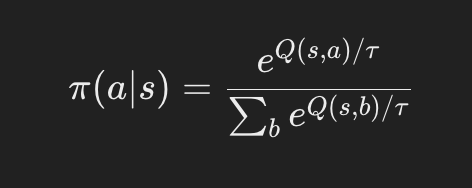


While ε-greedy is a deterministic strategy that selects actions based on Q-values with a certain probability (ε) and randomly otherwise, softmax is a probabilistic strategy that assigns probabilities to each action based on their Q-values.

In [ ]:
# Number of runs
num_runs = 1000


np.random.seed(seed)

# For beta = 0.01
avg_r1 = []
# For beta = 0.1
avg_r2 = []
# For beta = 1
avg_r3 = []
# For beta = 5
avg_r4 = []

avg_mu_star = 0


for run in range(num_runs):

    mus_run = np.random.randn(num_arms)
    avg_mu_star += np.max(mus_run)

    q1, rewards1 = softmax(temp=0.01, num_arms = num_arms, mus = mus_run)
    q2, rewards2 = softmax(temp=0.1, num_arms = num_arms, mus = mus_run)
    q3, rewards3 = softmax(temp=1, num_arms = num_arms, mus = mus_run)
    q3, rewards4 = softmax(temp=5, num_arms = num_arms, mus = mus_run)


    avg_r1.append(rewards1)
    avg_r2.append(rewards2)
    avg_r3.append(rewards3)
    avg_r4.append(rewards4)

avg_mu_star /= num_runs


avg_r1 = np.array(avg_r1).mean(axis=0)
avg_r2 = np.array(avg_r2).mean(axis=0)
avg_r3 = np.array(avg_r3).mean(axis=0)
avg_r4 = np.array(avg_r4).mean(axis=0)

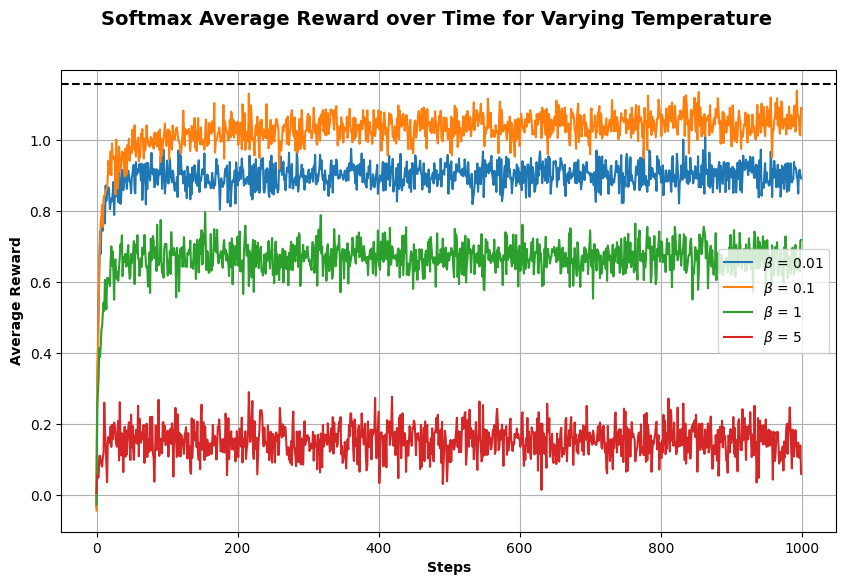

In [ ]:
# Helper code to plot the average rewards

reqd_plots = [(avg_r1, '$\\beta$ = 0.01'),
            (avg_r2, '$\\beta$ = 0.1'),
            (avg_r3, '$\\beta$ = 1'),
            (avg_r4, '$\\beta$ = 5')]

runs_plotter(title = 'Softmax Average Reward over Time for Varying Temperature',
        xlbl = 'Steps', ylbl = 'Average Reward', plots = reqd_plots,
        mu_star = avg_mu_star)